In [0]:
!wget "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
!wget "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

In [0]:
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip -d Flickr8k_text
# # !ls Flicker8k_Dataset/
# !cat Flickr8k_text/Flickr_8k.trainImages.txt
# !cat Flickr8k_text/readme.txt

In [0]:
'''
Extract, Clean, and Save Descriptions.
'''

import string
import pickle

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	max_len = 0
	all_desc = set()
	for key in descriptions.keys():
		length = max(len(d.split()) for d in descriptions[key])
		if length>max_len:
			max_len = length
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc, max_len

# # save descriptions to file, one per line
# def save_descriptions(descriptions, filename):
# 	lines = list()
# 	for key, desc_list in descriptions.items():
# 		for desc in desc_list:
# 			lines.append(key + ' ' + desc)
# 	data = '\n'.join(lines)
# 	file = open(filename, 'w')
# 	file.write(data)
# 	file.close()

filename = '/content/Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary and get max_length
vocabulary, max_length = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
#save descriptions dictionary to a pickle file
with open('descriptions.pickle', 'wb') as handle:
    pickle.dump(descriptions, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # save to file
# save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [0]:
'''
Load Training Data, Image Features, and Clean Text Descriptions
'''
import pickle

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load pickle file
def load_pickle_file(filepath):
  with open(filepath, 'rb') as handle:
    captions = pickle.load(handle)
  return captions

def load_clean_descriptions(filepath, dataset):
	# load document
  captions = load_pickle_file(filepath)
  descriptions = dict()
  for image_id in dataset:
    desc_list = captions[image_id]
    for i in range(len(desc_list)):
      desc_list[i] = 'startseq ' + ' '.join(desc_list[i].split()) + ' endseq'
    descriptions[image_id] = desc_list
  return descriptions

# load training dataset (6K)
filename = '/content/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/content/descriptions.pickle', train)
print('Descriptions: train=%d' % len(train_descriptions))


Dataset: 6000
Descriptions: train=6000


In [0]:
'''
Make a tokenizer
'''
from tensorflow.keras.preprocessing.text import Tokenizer

top_k_words = 5000
tokenizer = Tokenizer(num_words=top_k_words, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
train_captions = list()
for key, value in train_descriptions.items():
  [train_captions.append(cap_text) for cap_text in value]

tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
!cp /content/drive/My\ Drive/capgen-data/numpy-features.zip /content/

In [0]:
# !mkdir numpy-features
!unzip /content/numpy-features.zip -d numpy-features
# !ls /content/

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
'''
Generator function to prepare the dataset
Apply VGG19 features and save them
Process the captions for training
'''
from PIL import Image
from os import listdir, path
import os
import tensorflow as tf
from pickle import load, dump
# from tf.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
# from keras.applications.vgg16 import preprocess_input
import numpy as np

tf.compat.v1.enable_eager_execution()
temp = tf.random_uniform([1, 224, 224, 3])  # Or tf.zeros
tf.keras.applications.vgg19.preprocess_input(temp)

def resize_image(image):
    width, height = image.size
    if width > height:
        left = (width - height) / 2
        right = width - left
        top = 0
        bottom = height
    else:
        top = (height - width) / 2
        bottom = height - top
        left = 0
        right = width
    image = image.crop((left, top, right, bottom))
    image = image.resize([224, 224], Image.ANTIALIAS)
    return image

def load_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  # image = resize_image(image)
  image = tf.image.resize(image, (224, 224))
  # image = img_to_array(image)
  # image = tf.expand_dims(image, 0)
  image = tf.keras.applications.vgg19.preprocess_input(image)
  return image, image_path

def preprocess_image(image):
  '''features for an image at image_path'''
  # even though the paper mentions 4th Conv layer before pool, this layer has 14x14x512 shape
  extract_layer = ['block4_pool'] 
  feature_extractor = vgg_layers(extract_layer)
  feature_output = feature_extractor(image)
  feature_output = tf.reshape(feature_output,[-1,196,512])
  # image_id = name.split('.')[0]
  # features[image_id] = feature_output
  # print('>%s' %image_id, feature_output.shape, idx)
  # if (idx+1)%100 is 0:
  #   iteration = (idx+1)/100
  #   dump(features, open('/content/temp/features%s.pkl' %iteration , 'wb'))
  #   print('Done with %s iteration' %iteration)
  #   features.clear()
  # time.sleep(2)
  return feature_output

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def getTokenizer(path):
  with open(path, 'rb') as f:
    tokenizer = load(f)
  return tokenizer

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

def create_sequences(tokenizer, max_length, desc_list, photo_features, vocab_size):  # change this to handle lists
    train_seqs = tokenizer.texts_to_sequences(desc_list)
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)
    # Calculates the max_length, which is used to store the attention weights
    im_input = [photo_features]*len(desc_list)
    return im_input, cap_vector


# data generator, intended to be used in a call to model.fit_generator()
def data_generator(image_directory, file_list, descriptions, tokenizer, max_length, vocab_size):
  # loop for ever over images
  while 1:
    for filename in file_list:
      filepath = image_directory + '/' + filename
      photo_features = preprocess_image(filepath)
      ## get the descriptions from the
      desc_list = descriptions[filename]
      for desc in desc_list:
        seq_vector = tokenizer.texts_to_sequences(desc)
        cap_vector = tf.keras.preprocessing.sequence.pad_sequences(seq_vector, padding='post', maxlen=max_length)
        # im_input, seq_output= create_sequences(tokenizer, max_length, desc_list, photo_features, vocab_size)   #check again
        yield [im_input, cap_vector]

def generate_caption_list(train_list, train_descriptions):
  captions = list()
  images = list()
  for key, value in train_descriptions.items():
    for desc in value:
      captions.append(desc)
      images.append(key)
      # print(key)
  return captions, images

def process_train_images(image_directory, train_list, startIndex, endIndex):
  for p in range(startIndex, endIndex):
    filename = train_list[p]
    filepath = image_directory + '/%s.jpg' %filename
    features = preprocess_image(filepath)
    save_to = '/content/numpy-features/' + '%s.jpg' %filename
    # save_to = save_to.numpy().decode("utf-8")
    np.save(save_to, features)
    print('saved to %s' %save_to, 'Index: ', p)


# train the model, run epochs manually and save after each epoch
tokenizer = getTokenizer('/content/tokenizer.pickle')
epochs = 20
steps = len(train_descriptions)
train_list = load_set('/content/Flickr8k_text/Flickr_8k.trainImages.txt')
image_directory = '/content/Flicker8k_Dataset'
captions, images_name = generate_caption_list(train_list, train_descriptions)
print(captions[0])
print(captions[1])
# bucket_size = 100
# i = 0
# isLast = False
# train_list = list(train_list)
# while isLast is False:
#   startIndex = i*bucket_size
#   endIndex = startIndex + bucket_size
#   if endIndex>=len(train_list):
#     endIndex = len(train_list)
#     isLast = True
#   process_train_images(image_directory, train_list, startIndex, endIndex)
#   i+=1

def already_present(path):
  ap = [os.path.splitext(os.path.splitext(filename)[0])[0] for filename in listdir(path) if filename.endswith(".npy")]
  print(ap[0])
  return ap

# prev_list = already_present('/content/Flicker8k_Dataset')
prev_list = already_present('/content/numpy-features/content/numpy-features')
print('already_present: ', len(prev_list))
encode_train = [image_directory + '/%s.jpg' %filename for filename in train_list if filename not in prev_list]
print('now_left: ', len(encode_train))
if len(encode_train)!=0:
  # Feel free to change batch_size according to your system configuration
  image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
  image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

  Index = 0
  for img, path in image_dataset:
    batch_features = preprocess_image(img)
    # batch_features = tf.reshape(batch_features,
    #                             (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
      path_of_feature = p.numpy().decode("utf-8")
      np.save(path_of_feature, bf.numpy())
      print('saved to %s' %p, 'Index: ', Index)
      Index +=1


train_seqs = tokenizer.texts_to_sequences(captions)
caption_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)  



startseq man in sunglasses and neatly trimmed beard overlooks woody valley endseq
startseq man posing with large grassy mountains off in the distance endseq
3329793486_afc16663cc
already_present:  6000
now_left:  0


In [0]:
# !zip -r numpy-features.zip /content/numpy-features/

In [0]:
# # !cp -r /content/Flicker8k_Dataset/*.npy /content/numpy-features/
# prev_list = already_present('/content/numpy-features')
# print('already_present: ', len(prev_list))

In [0]:
# !find /content/Flicker8k_Dataset/ -name "*.npy" -type f -delete

In [0]:
# # summarize vocabulary and get max_length
# vocabulary, max_length = to_vocabulary(descriptions)
vocab_size = len(vocabulary)
# max_length = 16  # computed with vocabulary
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256 #embedding output
units = 512 #lstm output
vocab_size += 1
num_steps = len(images_name) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 512
attention_features_shape = 196

# Load features with captions
def map_func(filename, caption):
  # image_directory = '/content/Flicker8k_Dataset/%s.jpg' % filename
  filepath = '/content/numpy-features/content/numpy-features/%s.jpg.npy' % filename.decode('utf-8')
  # filepath = path.join(image_directory, "%s.jpg" % filename)
  # image_features = preprocess_image(filepath)
  image_features = np.load(filepath)
  # print(filepath)
  return image_features, caption

# train_size = 6000
dataset = tf.data.Dataset.from_tensor_slices((images_name, caption_vector)) # [:train_size]

# Use map to load the features files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# dataset = tf.data.Dataset.from_generator(data_generator(image_directory, train_list, train_descriptions, tokenizer, max_length, vocab_size), (tf.float32, tf.float32))
# dataset = tf.data.Dataset.from_generator([(preprocess_image(image_directory + '/' + images_name[i] + '.jpg'), caption_vector[i]) for i in range(len(images_name))], (tf.float32, tf.float32))

In [0]:
'''
The Model
'''
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights
  
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state, _ = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])




In [0]:
import time

# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function
def training_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)  #BATCH_SIZE

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

train_step = tf.function(training_step)

EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 1 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1 Batch 0 Loss 2.8595
Epoch 1 Batch 100 Loss 1.7928
Epoch 1 Batch 200 Loss 1.8634
Epoch 1 Batch 300 Loss 2.0357
Epoch 1 Batch 400 Loss 1.8693
Epoch 1 Loss 1.842354
Time taken for 1 epoch 458.3052270412445 sec

Epoch 2 Batch 0 Loss 1.7821
Epoch 2 Batch 100 Loss 1.7509
Epoch 2 Batch 200 Loss 1.8537
Epoch 2 Batch 300 Loss 2.0059
Epoch 2 Batch 400 Loss 1.8549
Epoch 2 Loss 1.809666
Time taken for 1 epoch 245.47710728645325 sec

Epoch 3 Batch 0 Loss 1.7764
Epoch 3 Batch 100 Loss 1.7616
Epoch 3 Batch 200 Loss 1.8468
Epoch 3 Batch 300 Loss 2.0159
Epoch 3 Batch 400 Loss 1.8512
Epoch 3 Loss 1.804178
Time taken for 1 epoch 245.03547930717468 sec

Epoch 4 Batch 0 Loss 1.7713
Epoch 4 Batch 100 Loss 1.7491
Epoch 4 Batch 200 Loss 1.8469
Epoch 4 Batch 300 Loss 2.0006
Epoch 4 Batch 400 Loss 1.8457
Epoch 4 Loss 1.801690
Time taken for 1 epoch 244.62682819366455 sec

Epoch 5 Batch 0 Loss 1.7620
Epoch 5 Bat

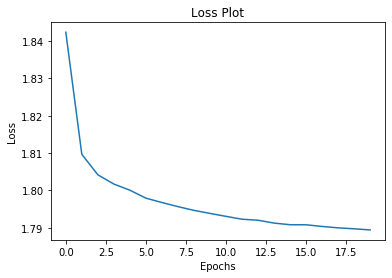

In [0]:
import matplotlib.pyplot as plt
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [0]:
# from google.colab import files
# files.download('/content/numpy-features.zip') 

In [0]:
'''
Evalulate the model
'''
import matplotlib.pyplot as plt

def evaluate(image_path):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image_path)[0], 0)
    img_tensor_val = preprocess_image(temp_input)
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        # if tokenizer.index_word[predicted_id] == 'endseq':
        #     return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(50, 50))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (45, 45))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Prediction Caption: endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


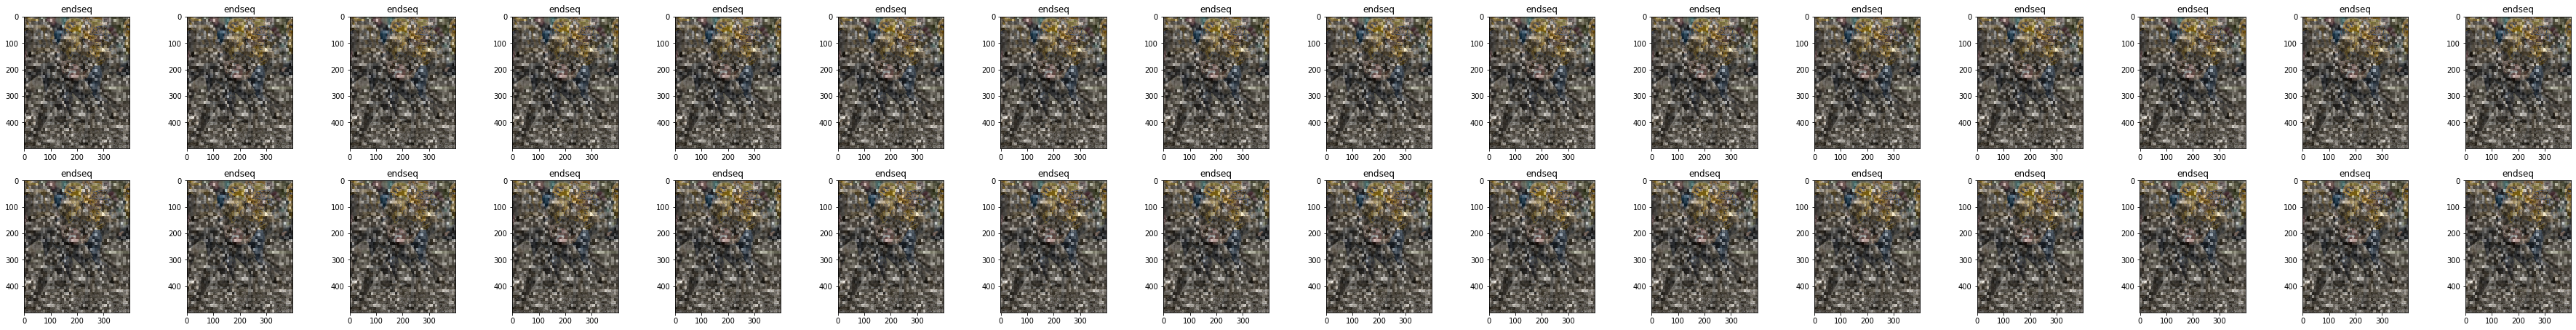

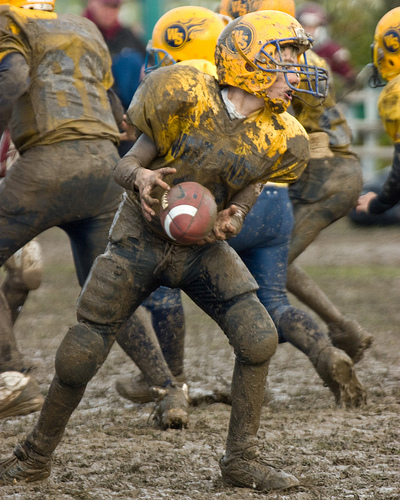

In [0]:
# captions on the validation set
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
'''
Get an image from the validation set
'''
filename = '/content/Flickr8k_text/Flickr_8k.devImages.txt'
val_list = list(load_set(filename))
rid = np.random.randint(0, len(val_list))
image_id = val_list[rid]
image_directory = '/content/Flicker8k_Dataset'  #check if dataset folder exists 
image_path = image_directory + '/%s.jpg' %image_id
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
# real_caption = train_descriptions[image_id + '.jpg'][0]
result, attention_plot = evaluate(image_path)

# print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [0]:
# !cp -r /content/checkpoints /content/drive/My\ Drive/capgen-data/